# ECUACIÓN DEL CALOR PLACA

Buscamos 
$$
\begin{align*}
u_t - \Delta u &= f \quad \text{en } \Omega    \times (0,T)
\\
u|_{\partial \Omega} &= g \quad \text{en } \partial\Omega    \times (0,T)
\\
u(0) &= u_0 \quad\text{en } \Omega
\end{align*}
$$

$$
u(x,y,t) = t\cdot (1-(x^2+y^2) )
$$
en 
$$\Omega=[0,1]\times[0,1]$$

$$
u_t - u_{xx} - u_{yy} = 1-(x^2+y^2)  + 4t = f(x,y,t)
\\
u|_{\partial\Omega}=0
\\
u(0)=0
$$

In [3]:
Threads.nthreads()

16

In [4]:
using Gridap
import Gridap: ∇

## Solución exacta

In [5]:
#En primer lugar vamos a definir la expresión de la solución ya conocida

u_exacta(x) = (x[1]*x[1]-x[1])*(x[2]*x[2]-x[2])*t

u_exacta (generic function with 1 method)

In [6]:
#Mallado
domain = (0,1,0,1)
partition = (20,20)
model = CartesianDiscreteModel(domain,partition)
model=simplexify(model)
trian = Triangulation(model)
degree = 1
quad = CellQuadrature(trian,degree)

dt_ex = 1/N_intervalos

UndefVarError: UndefVarError: N_intervalos not defined

In [7]:
for i=1:N_intervalos+1
    t=(i-1)*dt_ex
    writevtk(trian,"Sol_exacta$(lpad(i,2,'0'))",cellfields=["u_exacta" => u_exacta])
end 

UndefVarError: UndefVarError: N_intervalos not defined

## Solución numérica

In [8]:
#Parámetros
t = 0.
g(x) = 0  #valor en la frontera
f(x) = (x[1]*x[1]-x[1])*(x[2]*x[2]-x[2]) - 2*(x[2]*x[2]-x[2])*t - (x[1]*x[1]-x[1])*2*t  #fuente de calor
beta = 1.
u0(x) = 0.  #valor inicial

t_init, t_end = 0., 1.
n_t = 10;
dt = (t_end - t_init)/n_t;
N_intervalos = 10;
n_iter = 8;
T = LinRange(t_init, t_end, N_intervalos+1)


11-element LinRange{Float64}:
 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0

In [9]:
#Espacio de funciones
order = 1
V0 = TestFESpace(
  reffe=:Lagrangian, order=order, valuetype=Float64,
  conformity=:H1, model=model, dirichlet_tags="boundary")

U = TrialFESpace(V0,g)


TrialFESpace()

In [10]:
function EulerMEF(t_init,t_end,n_t,u0)
    dt = (t_end - t_init)/n_t
    u_sol = u0
    t = t_init
    f(x) = (x[1]*x[1]-x[1])*(x[2]*x[2]-x[2]) - 2*(x[2]*x[2]-x[2])*t - (x[1]*x[1]-x[1])*2*t
    
    a(u,v) = dt * beta*∇(v)*∇(u) + u*v
    b(v) = v*dt*f + v*u0
    
    for i=1:n_t
        t += dt
        t_Ω = AffineFETerm(a,b,trian,quad)
        op = AffineFEOperator(U,V0,t_Ω)
        u_sol = solve(op)
        
        u0 = u_sol
    end
    return u_sol
end 
    

EulerMEF (generic function with 1 method)

In [11]:
t_n_f = 70;
t_n_c = 10;

F(t1, t0, u0) =  EulerMEF(t0, t1, t_n_f,u0)
G(t1, t0, u0) =  EulerMEF(t0, t1, t_n_c,u0)

G (generic function with 1 method)

In [12]:
#Función de Gridap con el valor inicial 
f2(x) = 0

U_u0 = TrialFESpace(V0,g)

a_u0(u,v) =  beta*∇(v)*∇(u) + u*v
b_u0(v) = v*f2 + v*u0

t_Ω_u0 = AffineFETerm(a_u0,b_u0,trian,quad)
op_u0 = AffineFEOperator(U_u0,V0,t_Ω_u0)

u0_guardar = solve(op_u0)

typeof(u0_guardar)

Gridap.FESpaces.SingleFieldFEFunction{true}

In [1]:
function EDP_secuencial()
    U = Array{Gridap.Geometry.GenericCellField{true},2}(undef, N_intervalos+1, n_iter+1);
    F_sol = Array{Gridap.Geometry.GenericCellField{true},1}(undef, N_intervalos+1);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1] = 1*u0_guardar

    for n=1:N_intervalos
        U[n+1,1] = 1*G( T[n+1],T[n],U[n,1] )
    end
        
    # 1.b) Inicialización etapas parareal
    for k=1:n_iter
        U[1,k+1] = 1*u0_guardar
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        for n = 1:N_intervalos
            F_sol[n] = 1*F( T[n+1], T[n], U[n,k] )
        end
        
        # 2.b) Corrección secuencial
        for n = 1:N_intervalos
            U[n+1, k+1] = F_sol[n] + G( T[n+1], T[n], U[n,k+1] ) - G( T[n+1], T[n], U[n,k] )
        end
    end
    
    return U
    
end

EDP_secuencial (generic function with 1 method)

In [2]:
function EDP_parareal()
    U = Array{Gridap.Geometry.GenericCellField{true},2}(undef, N_intervalos+1, n_iter+1);
    F_sol = Array{Gridap.Geometry.GenericCellField{true},1}(undef, N_intervalos+1);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1] = 1*u0_guardar

    for n=1:N_intervalos
        U[n+1,1] = 1*G( T[n+1],T[n],U[n,1] )
    end
        
    # 1.b) Inicialización etapas parareal
    @inbounds Threads.@threads for k=1:n_iter
        U[1,k+1] = 1*u0_guardar
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @inbounds Threads.@threads for n = 1:N_intervalos
            F_sol[n] = 1*F( T[n+1], T[n], U[n,k] )
        end
        
        # 2.b) Corrección secuencial
        for n = 1:N_intervalos
            U[n+1, k+1] = F_sol[n] + G( T[n+1], T[n], U[n,k+1] ) - G( T[n+1], T[n], U[n,k] )
        end
    end
    
    return U
    
end

EDP_parareal (generic function with 1 method)

In [15]:
@time U1 = EDP_secuencial();

121.508107 seconds (379.53 M allocations: 28.236 GiB, 5.29% gc time)


In [16]:
@time U2 = EDP_parareal();

 50.494097 seconds (363.24 M allocations: 27.407 GiB, 27.81% gc time)


In [17]:
for i=1:N_intervalos+1
    sol = U2[i,end]
    writevtk(trian,"Sol_numerica$(lpad(i,2,'0'))",cellfields=["sol" => sol])
end 

## Error

In [18]:
for i=1:N_intervalos+1
    t=(i-1)*dt_ex
    e = u_exacta - U2[i,end]
    writevtk(trian,"Error_t$(lpad(i,2,'0'))",cellfields=["e" => e])
end 

UndefVarError: UndefVarError: dt_ex not defined

In [19]:
# Error en norma L2 para cada subintervalo temporal

l2(w) = w*w


error_L2 = Array{Any,1}(undef, N_intervalos+1);

for i=1:N_intervalos+1
    el2 = sqrt(sum( integrate(l2(U2[i,end]-u_exacta),trian,quad) ))
    error_L2[i] = el2
end 

In [20]:
using Plots

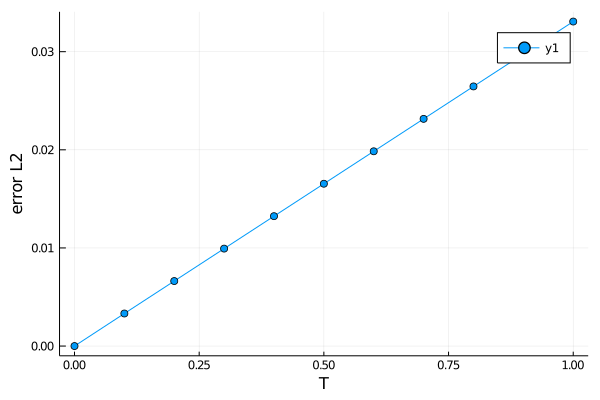

In [21]:
plot(T,error_L2,
    shape=:auto,
    xlabel="T",ylabel="error L2")

In [22]:
U2

11×9 Array{Gridap.Geometry.GenericCellField{true},2}:
 GenericCellField()  GenericCellField()  …  GenericCellField()
 GenericCellField()  GenericCellField()     GenericCellField()
 GenericCellField()  GenericCellField()     GenericCellField()
 GenericCellField()  GenericCellField()     GenericCellField()
 GenericCellField()  GenericCellField()     GenericCellField()
 GenericCellField()  GenericCellField()  …  GenericCellField()
 GenericCellField()  GenericCellField()     GenericCellField()
 GenericCellField()  GenericCellField()     GenericCellField()
 GenericCellField()  GenericCellField()     GenericCellField()
 GenericCellField()  GenericCellField()     GenericCellField()
 GenericCellField()  GenericCellField()  …  GenericCellField()

In [23]:
for i=1:n_iter+1
    t=1.
    e = u_exacta - U2[end,i]
    writevtk(trian,"Error_k$(lpad(i,2,'0'))",cellfields=["e" => e])
end 

In [24]:
# Error en norma L2 para cada subintervalo temporal

l2(w) = w*w


error_L2_k = Array{Any,1}(undef, n_iter+1);

for i=1:n_iter+1
    el2 = sqrt(sum( integrate(l2(U2[end,i]-u_exacta),trian,quad) ))
    error_L2_k[i] = el2
end 

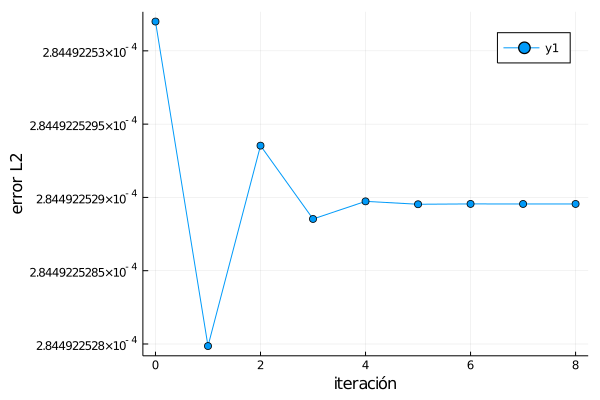

In [32]:
K = LinRange(0, n_iter, n_iter+1)
plot(K,error_L2_k,
    shape=:auto,
    xlabel="iteración",ylabel="error L2")